# Immune-checkpoint blockade (ICB) data

## Load data

To download and extract TSV version of ICB data from Zenodo (https://zenodo.org/record/7058399/files/), follow the script named download_tsv_data.py file at "~/Code/Download_Data". 


We read RNA-seq expression, clinicopathological characteristics, and gene meta data for the following selected ICB studies to include in meta-analysis. 

1. ICB Braun (PMID 32472114)
2. Nathanson (PMID 27956380)
3. Snyder (PMID 28552987)
4. Van Allen (PMID 26359337) 

As an example, we share the codes to get read the RNA-seq expression, clinicopathological characteristics, and gene meta data usign ICB Braun data. The Braun study includes 319 patients with clinical data and 40,994 genes. While only 181 patients have both clinical data and RNA-seq expression data. 

Note that the expression data is $log2(\text{TPM} + 0.001)$, where TPM represents transcripts per million. 


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
from statsmodels.stats.meta_analysis import (
    effectsize_smd,
    effectsize_2proportions,
    combine_effects,
    _fit_tau_iterative,
    _fit_tau_mm,
    _fit_tau_iter_mm,
)


### Braun study

In [2]:
## Braun 
# clinicopathological characteristics  
dat_sample_braun = pd.read_csv('ICB_Braun_metadata.tsv', sep='\t')

# gene meta data
dat_gene_braun = pd.read_csv('ICB_Braun_expr_genes.tsv', sep='\t')

# RNA-seq expression data (i.e., log2(TPM + 0.001)) 
dat_exp_braun = pd.read_csv('ICB_Braun_expr.tsv', sep='\t')

# Get the subset of data with both clinical and expression data.
dat_sample_braun_subset = dat_sample_braun.loc[dat_exp_braun.columns.values.tolist(), ]

### Nathanson study

In [3]:
## Nathanson 
# clinicopathological characteristics  
dat_sample_nathanson = pd.read_csv('ICB_Nathanson_metadata.tsv', sep='\t')

# gene meta data
dat_gene_nathanson = pd.read_csv('ICB_Nathanson_expr_genes.tsv', sep='\t')

# RNA-seq expression data (i.e., log2(TPM + 0.001)) 
dat_exp_nathanson = pd.read_csv('ICB_Nathanson_expr.tsv', sep='\t')

# Get the subset of data with both clinical and expression data.
dat_sample_nathanson_subset = dat_sample_nathanson.loc[dat_exp_nathanson.columns.values.tolist(), ]

### Snyder study

In [4]:
## Snyder
# clinicopathological characteristics  
dat_sample_snyder = pd.read_csv('ICB_Snyder_metadata.tsv', sep='\t')

# gene meta data
dat_gene_snyder = pd.read_csv('ICB_Snyder_expr_genes.tsv', sep='\t')

# RNA-seq expression data (i.e., log2(TPM + 0.001)) 
dat_exp_snyder = pd.read_csv('ICB_Snyder_expr.tsv', sep='\t')

# Get the subset of data with both clinical and expression data.
dat_sample_snyder_subset = dat_sample_snyder.loc[dat_exp_snyder.columns.values.tolist(), ]


### Van Allen study

In [5]:

## Van_Allen 
# clinicopathological characteristics  
dat_sample_van_allen = pd.read_csv('ICB_Van_Allen_metadata.tsv', sep='\t')

# gene meta data
dat_gene_van_allen = pd.read_csv('ICB_Van_Allen_expr_genes.tsv', sep='\t')

# RNA-seq expression data (i.e., log2(TPM + 0.001)) 
dat_exp_van_allen = pd.read_csv('ICB_Van_Allen_expr.tsv', sep='\t')

# Get the subset of data with both clinical and expression data.
dat_sample_van_allen_subset = dat_sample_van_allen.loc[dat_exp_van_allen.columns.values.tolist(), ]


## Logistic regression analysis 

For each study, we assess the association between genes and response variable (R vs NR) by fitting the logistic regression model. For a given gene, we fit the model under each study to identify the log(OR) and its standard error (SE). We consider a gene (e.g., ENSG00000065491.8 or TBC1D22B) that is in common across selected ICB studies.

In [13]:
# Braun 

y = dat_sample_braun_subset["response"]
x = dat_exp_braun.transpose()

x_subset = x.loc[:, "ENSG00000065491.8"]

df = pd.DataFrame({'x': x_subset, 
        'y': y}
)
df = df.dropna()

df["y"] = df["y"].map({"R": 0, "NR" : 1})

# fit logistic model

model_logit = smf.logit(formula="y ~ x", data=df)
res = model_logit.fit()

res_braun = ["Braun", 
             len(x_subset),
             round(res.params["x"], 4), 
             round(res.bse["x"], 4),
             round(res.pvalues["x"], 4)]


# Nathanson 

y = dat_sample_nathanson_subset["response"]
x = dat_exp_nathanson.transpose()

x_subset = x.loc[:, "ENSG00000065491.8"]

df = pd.DataFrame({'x': x_subset, 
        'y': y}
)
df = df.dropna()

df["y"] = df["y"].map({"R": 0, "NR" : 1})

# fit logistic model

model_logit = smf.logit(formula="y ~ x", data=df)
res = model_logit.fit()

res_nathanson = ["Nathanson", 
             len(x_subset),
             round(res.params["x"], 4), 
             round(res.bse["x"], 4),
             round(res.pvalues["x"], 4)]


# Snyder

y = dat_sample_snyder_subset["response"]
x = dat_exp_snyder.transpose()

x_subset = x.loc[:, "ENSG00000065491.8"]

df = pd.DataFrame({'x': x_subset, 
        'y': y}
)
df = df.dropna()

df["y"] = df["y"].map({"R": 0, "NR" : 1})

# fit logistic model

model_logit = smf.logit(formula="y ~ x", data=df)
res = model_logit.fit()

res_snyder = ["Snyder", 
             len(x_subset),
             round(res.params["x"], 4), 
             round(res.bse["x"], 4),
             round(res.pvalues["x"], 4)]


# Van_Allen

y = dat_sample_van_allen_subset["response"]
x = dat_exp_van_allen.transpose()

x_subset = x.loc[:, "ENSG00000065491.8"]

df = pd.DataFrame({'x': x_subset, 
        'y': y}
)
df = df.dropna()

df["y"] = df["y"].map({"R": 0, "NR" : 1})

# fit logistic model

model_logit = smf.logit(formula="y ~ x", data=df)
res = model_logit.fit()

res_van_allen = ["Van_Allen", 
             len(x_subset),
             round(res.params["x"], 4), 
             round(res.bse["x"], 4),
             round(res.pvalues["x"], 4)]


Optimization terminated successfully.
         Current function value: 0.553173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.529296
         Iterations 5


## Meta-analysis 

Meta-analyses can be performed to integrate independent studies to identify more reliable findings by increasing statistical power and reducing false positives. The strengths and limitations of meta-analyses are
evaluated particularly with respect to their ability to assess variation across studies or heterogeneity. Several meta-analysis methods have been proposed such as combining p-values, combining effect estimates, and rankings. 

Approaches that combine effects including fixed- and random-effects (FE & RE) models are widely used to achieve a broad inferential basis for evaluations of effects. Under the FE model, we assume that there is one true effect that underlies all the studies in the analysis, and that all differences in
observed effects are due to sampling error. In contrast, the RE model incorporates the variability of the effects across studies in addition to the within-study variability using a two-stage hierarchical process. 

Assessing heterogeneity is a critical issue in meta-analysis because different models may lead to different estimates of overall effect and different standard errors.Several approaches have been suggested over the years for how best to assess homogeneity across studies, and the corresponding research is ongoing. erSimonian and Laird (DL) (or chi2) is widely used to assess the hetergeneity.

### Part I: response (R vs. NR)

The forest plot demonstrates the fitted logistic regression model under each study including  the logOR, SE and p-value. Then, the meta-analysis was applied to integrate the results across studies using DL method to estimate heterogeneity. Under the FE meta-analysis, the gene is associated with OS, while under the RE meta-analysis, the forestplot does not show any significant association.       



In [16]:
data = [
        res_braun,
        res_nathanson,
        res_snyder,
        res_van_allen,
]

colnames = ["study","n", "logOR", "SE", "Pvalue"]
rownames = [i[0] for i in data]
dframe1 = pd.DataFrame(data, columns=colnames)
rownames

eff = [row[2] for row in data]
eff = np.array(eff)
print(eff)

se_eff = [row[3] for row in data]
se_eff = np.array(se_eff)
print(se_eff)

pval_eff = [row[4] for row in data]
var_eff = np.array(pval_eff)
print(pval_eff)


[ 0.9834 -0.8841  0.4076 -0.7336]
[0.3277 0.9136 0.752  0.8009]
[0.0027, 0.3332, 0.5878, 0.3597]


In [19]:
res3 = combine_effects(eff, var_eff, method_re = "chi2", row_names = rownames)

print(res3.summary_frame())


                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Braun              0.983400  0.051962  0.881557  1.085243  0.980197  0.315947
Nathanson         -0.884100  0.577235 -2.015459  0.247259  0.007943  0.241842
Snyder             0.407600  0.766681 -1.095067  1.910267  0.004502  0.204832
Van_Allen         -0.733600  0.599750 -1.909088  0.441888  0.007358  0.237378
fixed effect       0.953341  0.051444  0.852512  1.054171  1.000000       NaN
random effect      0.006239  0.583761 -1.137912  1.150390       NaN  1.000000
fixed effect wls   0.953341  0.129075  0.700359  1.206324  1.000000       NaN
random effect wls  0.006239  0.467731 -0.910498  0.922976       NaN  1.000000


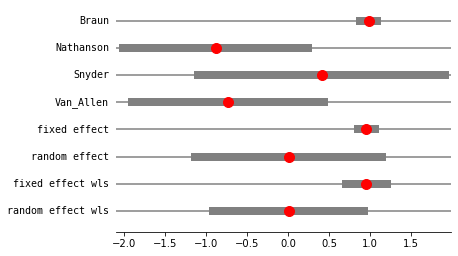

In [18]:
# forestplot

fig = res3.plot_forest()

